<a href="https://colab.research.google.com/github/jesusvc5/RL_LAVC/blob/main/MonteCarloOffPolicy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#@title Instalamos gym
!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

In [2]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym


In [3]:
# Intentamos fijar las semillas
import os
import torch

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

SEED = 123

# Fijar la semilla en NumPy
np.random.seed(SEED) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(SEED) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(SEED) # Evita variabilidad en hashing de Python

# Fijar la semilla en Gymnasium
def make_env(env_name, map="4x4"):
  env = gym.make(env_name, is_slippery=False, map_name=map, render_mode="ansi")
  env.reset(seed=SEED) # Establece la semilla en el entorno de Gymnasium
  return env

Usando dispositivo: cpu


In [4]:
#@title Importamos el lago helado
name = 'FrozenLake-v1'
env4 = make_env(name, "4x4")
env8 = make_env(name, "8x8")

#### **Código de las políticas y algoritmo MC**
----------------

**Según Gymnasium:**

**Definición del agente:**

In [16]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

class AgentMonteCarloOffPolicy:
  def __init__(self,
               env:gym.Env,
               epsilon:float,
               decay:bool,
               discount_factor:float,
               factor_ini:float):
    """Inicializa todo lo necesario para el aprendizaje"""
    self.env = env
    self.epsilon = epsilon
    self.decay = decay
    self.discount_factor = discount_factor
    self.returns = {}
    self.nA = env.action_space.n
    self.nS = env.observation_space.n
    # Cada vez que se hace self.q_values[state] para un state nuevo, se crea un nuevo espacio de valores Q(state,a), para cada acción
    #self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
    self.Q = np.zeros((self.nS, self.nA))
    #self.n_visits = np.zeros((self.nS, self.nA))
    self.C = np.zeros((self.nS, self.nA))
    self.factor_ini = factor_ini

  def set_epsilon(self, eps):
    self.epsilon = eps

  def get_epsilon(self):
    return self.epsilon

  def get_decay(self):
    return self.decay

  def get_discount_factor(self):
    return self.discount_factor

  def get_Q(self):
    return self.Q

  def set_return(self, state, action, G):
    self.returns[(state, action)].append(G)

  def get_return(self, state, action):
    return self.returns[(state, action)]


  """
  Indicará qué acción realizar de acuerdo al estado.
  Responde a la política del agente.
  Construir tantas funciones de este tipo como políticas se quieran usar.
  """

  # Política uniforme (es soft-policy también)
  '''
  def behavior_policy(self, state):
    return np.random.choice(self.nA)
  '''

  # Política epsilon-soft
  def get_action_epsilon_soft(self, state):
    pi_A = np.ones(self.nA, dtype=float) * self.epsilon / self.nA
    best_action = np.argmax(self.Q[state])
    pi_A[best_action] += (1.0 - self.epsilon)
    return pi_A

  # Política de comportamiento b. Soft policy (usamos una epsilon-greedy)
  def get_action_behavior_policy( self, state):
    pi_A = self.get_action_epsilon_soft(state)
    return np.random.choice(np.arange(self.nA), p=pi_A)

  def get_pi_behavior_policy(self, state, action):
    pi_A = self.get_action_epsilon_soft(state)
    return pi_A[action]

  def target_policy(self, state):
    return np.argmax(self.Q[state])


  # Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
  def get_action_greedy_from_Q(self, env):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(self.Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

  def update(self, episode):
    G = 0
    W = 1
    factor = self.discount_factor # el gamma

    for step in reversed(range(len(episode))):
      state, action, reward = episode[step]
      G = reward + factor * G
      self.C[state, action] += W
      self.Q[state, action] += (W/self.C[state, action]) * (G - self.Q[state, action])
      if action != self.target_policy(state):
        break
      W = W * 1/self.get_pi_behavior_policy(state, action)

    return G




**Algoritmo:**

In [17]:
import gymnasium as gym

def off_policy_all_visit(agent, num_episodes):
  stats = 0.0
  list_stats = [stats]
  list_len = []
  step_display = num_episodes / 10
  np.random.seed(SEED)
  for t in tqdm(range(n_episodes)):
    state, info = agent.env.reset(seed=SEED)
    done = False

    episode = []
    result_sum = 0.0
    #G = []
    #factor_list = []
    #rewards = []

    # play one episode
    while not done:
      if agent.get_decay():
        agent.set_epsilon(min(1.0, 1000.0/(t+1)))

      # get action
      action = agent.get_action_behavior_policy(state)
      next_state, reward, terminated, truncated, info = agent.env.step(action)
      #print(f'State: {state}; Action: {action}; Recompensa:{reward}')
      #rewards.append(reward)
      episode.append((state, action, reward))
      #result_sum += reward

      # update the agent
      #agent.update_returns(G, factor_list, reward)
      #for i, g in enumerate(G):
      #  print(f'G_{i}:= {g}')

      # update if the environment is done and the current obs
      done = terminated or truncated
      #factor *= agent.get_discount_factor()
      state = next_state
      #print("------------------------")

    result_sum = agent.update(episode)#, rewards)
    #print('*************************')

    # Guardamos datos sobre la evolución
    stats += result_sum
    list_stats.append(stats/(t+1))
    list_len.append(len(episode))

    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if t % step_display == 0 and t != 0:
      print(f"success: {stats/t}, epsilon: {agent.get_epsilon()}")

  return list_stats, list_len


#stats = agent.stats() # Retorna los resultados estadísticos, evolución, etc ...

# Mostrar las estadísticas


In [7]:
# @title Funciones para mostrar los resultados

def plot(list_stats):
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

# Define la función para mostrar el tamaño de los episodios
# Pon aquí tu código.

In [8]:
def plot_len(list_len):
  indices = list(range(len(list_len)))

  plt.figure(figsize=(6, 3))
  plt.plot(indices, list_len)

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')

  plt.grid(True)
  plt.show()

### **3.2 Experimentación en el escenario 4x4**



   - Se realizan 5000 epsisodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ constante




In [18]:
# @title Aprendizaje
n_episodes = 50000
agent_4 = AgentMonteCarloOffPolicy(env4, epsilon=0.4, decay=False, discount_factor=1, factor_ini=1)

list_stats, list_len = off_policy_all_visit(agent_4, n_episodes)

 10%|█         | 5100/50000 [00:05<01:01, 735.38it/s]

success: 0.2044, epsilon: 0.4


 20%|██        | 10124/50000 [00:11<00:35, 1119.62it/s]

success: 0.2386, epsilon: 0.4


 30%|███       | 15114/50000 [00:15<00:30, 1141.82it/s]

success: 0.23466666666666666, epsilon: 0.4


 40%|████      | 20193/50000 [00:20<00:24, 1238.45it/s]

success: 0.23125, epsilon: 0.4


 50%|█████     | 25249/50000 [00:24<00:20, 1229.68it/s]

success: 0.226, epsilon: 0.4


 60%|██████    | 30198/50000 [00:28<00:15, 1274.28it/s]

success: 0.22396666666666668, epsilon: 0.4


 70%|███████   | 35166/50000 [00:35<00:16, 873.07it/s]

success: 0.22425714285714285, epsilon: 0.4


 80%|████████  | 40217/50000 [00:39<00:05, 1902.58it/s]

success: 0.240575, epsilon: 0.4


 90%|█████████ | 45145/50000 [00:42<00:04, 1111.77it/s]

success: 0.2567333333333333, epsilon: 0.4


100%|██████████| 50000/50000 [00:48<00:00, 1039.61it/s]


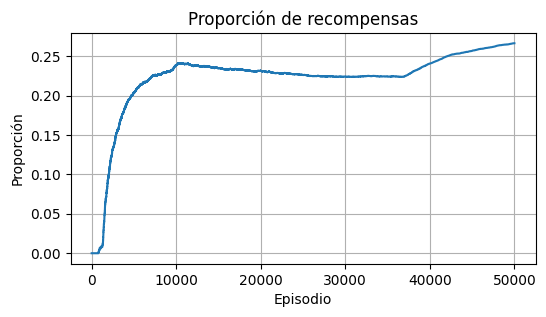

Máxima proporcion: 0.26636


In [19]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

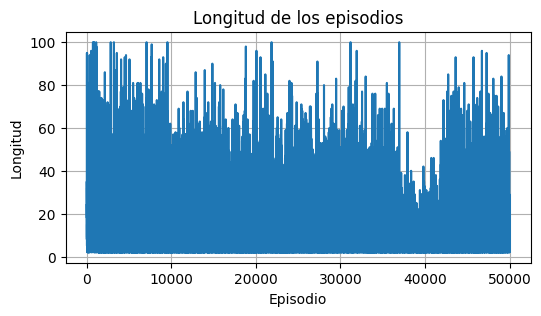

Longitud del último episodio: 14


In [20]:
# @title Longitud de los episodios

plot_len(list_len)
print(f"Longitud del último episodio: {list_len[-1]}")

####.
Mostramos los valores Q para cada estado. Cada estado tienen 4 valores, que se corresponden con las 4 acciones que se pueden en cada estado.

In [21]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", agent_4.get_Q())


Valores Q para cada estado:
 [[0.98573513 0.98323039 0.99961032 0.99661614]
 [0.99677307 0.         0.99948768 0.99636818]
 [0.99805591 0.99887246 0.99846045 0.99887755]
 [1.         0.         1.         1.        ]
 [0.98662642 0.         0.         0.98199369]
 [0.         0.         0.         0.        ]
 [0.         1.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [1.         0.         1.         1.        ]
 [1.         0.96401028 1.         0.        ]
 [0.         0.99984009 0.         0.99714404]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.98659004 0.99870298 0.        ]
 [0.99755779 0.99935762 1.         1.        ]
 [0.         0.         0.         0.        ]]


- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

In [22]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions = agent_4.get_action_greedy_from_Q(env4)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 3.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,  
 Para el siguiente grid
   (Up)
SFFF
FHFH
FFFH
HFFG




### **3.3 Experimentación en el escenario 8x8**

  - Se realizan 5000 epsisodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ decreciente



In [25]:
# @title Aprendizaje
n_episodes = 50000
agent_8 = AgentMonteCarloOffPolicy(env8, epsilon=0.4, decay=False, discount_factor=0.99, factor_ini=1)

list_stats, list_len = off_policy_all_visit(agent_8, n_episodes)

 10%|█         | 5024/50000 [00:25<03:45, 199.27it/s]

success: 0.0, epsilon: 0.4


 14%|█▍        | 7230/50000 [00:37<03:43, 191.67it/s]


KeyboardInterrupt: 

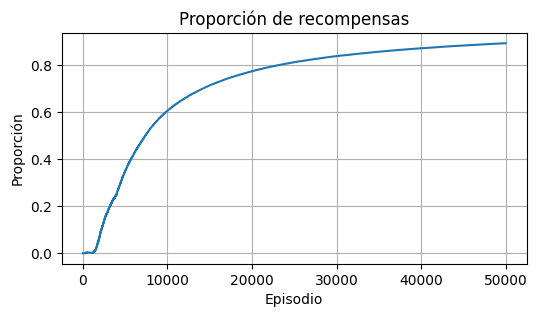

Máxima proporcion: 0.89422


In [ ]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

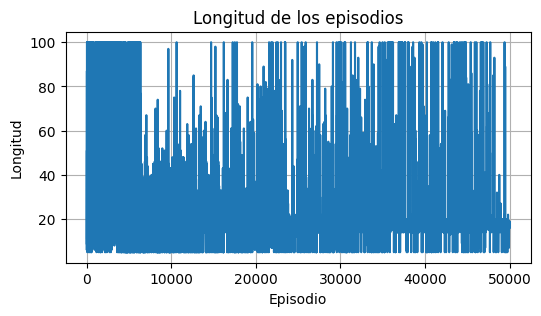

Longitud del último episodio: 16


In [ ]:
plot_len(list_len)
print(f"Longitud del último episodio: {list_len[-1]}")

####.
Mostramos los valores Q para cada estado. Cada estado tienen 4 valores, que se corresponden con las 4 acciones que se pueden en cada estado.

In [ ]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", agent_8.get_Q())

Valores Q para cada estado:
 [[0.2705955  0.26817349 0.84372832 0.26572008]
 [0.34447005 0.85225249 0.3748068  0.32855482]
 [0.08323831 0.11070999 0.53176044 0.11124547]
 [0.27094668 0.6412156  0.3038674  0.26227679]
 [0.59478022 0.65503356 0.95553126 0.70191455]
 [0.6822335  0.67673716 0.95901658 0.6468254 ]
 [0.72483221 0.96060071 0.77878104 0.73372093]
 [0.2        0.80340064 0.2745098  0.2       ]
 [0.43381356 0.26409603 0.25645791 0.27144428]
 [0.27467882 0.34263085 0.91805961 0.35903614]
 [0.46466809 0.45265279 0.92132176 0.4668435 ]
 [0.56317935 0.         0.92424449 0.55946844]
 [0.61392405 0.6166065  0.67665505 0.92334685]
 [0.2781457  0.29757785 0.79792945 0.30794702]
 [0.71655329 0.95755207 0.73880597 0.75391499]
 [0.36909871 0.84609053 0.40528634 0.44594595]
 [0.11495246 0.12489233 0.29223228 0.10289116]
 [0.1686747  0.13396716 0.19666374 0.3587385 ]
 [0.07801418 0.09350649 0.         0.5100426 ]
 [0.         0.         0.         0.        ]
 [0.         0.18548387 0.73817

- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

In [ ]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions = agent_8.get_action_greedy_from_Q(env8)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2,